## DOĞRULUK RAPORU

In [ ]:
# -*- coding: utf-8 -*-
# ==============================================================================
# Adım 1: Kurulum
# ==============================================================================
print("--- Adım 1: Gerekli kütüphaneler ve Ollama kuruluyor... ---")
!pip install ollama pandas pydantic tqdm openpyxl -q
!curl -fsSL https://ollama.com/install.sh | sh


# ==============================================================================
# Adım 2: Ollama Sunucusunu Başlatma ve Model Kontrolü
# ==============================================================================
print("\n--- Adım 2: Ollama sunucusu başlatılıyor ve Command-R modeli kontrol ediliyor... ---")
import os
import time
import subprocess
!pkill -f ollama
!nohup ollama serve > ollama.log 2>&1 &
print("Ollama sunucusunun başlatılması için 15 saniye bekleniyor...")
time.sleep(15)
print("\n--- Command-R modeli indiriliyor... ---")
pull_command = "ollama pull command-r"
result = subprocess.run(pull_command, shell=True, capture_output=True, text=True)
if result.returncode != 0:
    print("--- HATA: Model indirilemedi. ---"); print("Ollama'dan gelen hata mesajı:", result.stderr)
    raise RuntimeError("Ollama modeli 'command-r' indirilemedi.")
else:
    print("--- Model başarıyla indirildi. ---")
print("\n--- Sunucudaki modeller kontrol ediliyor... ---")
models_list_str = subprocess.check_output("ollama list", shell=True, text=True)
print(models_list_str)
if "command-r" not in models_list_str:
    raise RuntimeError("HATA: Model indirildi ancak listede görünmüyor.")
print("--- Kurulum ve model kontrolü başarıyla tamamlandı. ---")


# ==============================================================================
# Adım 3: Gerekli Kütüphaneler ve Veri Yükleme
# ==============================================================================
print("\n--- Adım 3: Kütüphaneler import ediliyor ve Excel dosyası isteniyor... ---")
import ollama
import pandas as pd
import json
from pydantic import BaseModel, ValidationError, Field
from typing import Literal, Dict, Any, List
from google.colab import files
from tqdm.notebook import tqdm
import warnings
import difflib

warnings.filterwarnings('ignore')
tqdm.pandas()

print("Lütfen 'trendyol_mila.xlsx' dosyasını yükleyin.")
uploaded = files.upload()
excel_filename = next((name for name in uploaded.keys() if name.endswith('.xlsx')), None)
if not excel_filename:
    raise ValueError("HATA: '.xlsx' uzantılı Excel dosyası yüklenmedi.")
df_sohbetler = pd.read_excel(excel_filename, sheet_name='sohbetler')
df_mesajlar = pd.read_excel(excel_filename, sheet_name='mesajlar')
print("--- Excel dosyası başarıyla yüklendi ve sayfalar okundu. ---")


# ==============================================================================
# Adım 4: Veri Ön İşleme (Sütun Adı Düzeltildi)
# ==============================================================================
print("\n--- Adım 4: Veri ön işleme yapılıyor... ---")
def format_dialogue(messages: pd.DataFrame) -> str:
    dialogue = []; messages = messages.sort_values(by='zaman')
    for _, row in messages.iterrows():
        dialogue.append(f"{row['gonderen']}: {row['metin']}")
    return "\n".join(dialogue)
dialogues = df_mesajlar.groupby('sohbet_id').apply(format_dialogue).reset_index(name='metin')
df_processed = pd.merge(df_sohbetler, dialogues, on='sohbet_id')
def create_ground_truth_json(row: pd.Series) -> Dict[str, Any]:
    return {"yanit_durumu": row["yanit_durumu"], "sentiment": row["sentiment"], "tur": row["tur"], "intent": row["intent"], "intent_detay": row["intent_detay"]}
df_processed['ground_truth'] = df_processed.apply(create_ground_truth_json, axis=1)
print(f"--- Toplam {len(df_processed)} adet sohbet analize hazır. ---")


# ==============================================================================
# Adım 5: Pydantic Şeması ve "Ultimate" Hibrit Prompt
# ==============================================================================
print("\n--- Adım 5: Pydantic şeması ve 'Ultimate' Hibrit Prompt hazırlanıyor... ---")
YANIT_DURUMU_ALLOWED=df_processed['yanit_durumu'].unique().tolist()
SENTIMENT_ALLOWED=df_processed['sentiment'].unique().tolist()
TUR_ALLOWED=df_processed['tur'].unique().tolist()
INTENT_ALLOWED=df_processed['intent'].unique().tolist()
INTENT_DETAY_ALLOWED=df_processed['intent_detay'].unique().tolist()

class UltimateIntentSchema(BaseModel):
    tur_aciklamasi: str = Field(description="Modelin 'tur' kategorisini neden seçtiğine dair kısa açıklaması.")
    yanit_durumu: Literal[tuple(YANIT_DURUMU_ALLOWED)]
    sentiment: Literal[tuple(SENTIMENT_ALLOWED)]
    tur: Literal[tuple(TUR_ALLOWED)]
    intent: Literal[tuple(INTENT_ALLOWED)]
    intent_detay: Literal[tuple(INTENT_DETAY_ALLOWED)]

PROMPT_ULTIMATE = f"""SİSTEM ROLÜ: Sen, e-ticaret sohbetlerini analiz eden ve sana verilen KESİN kurallara göre yapılandırılmış bir JSON üreten, çok yetenekli bir uzmansın. Görevin, tüm kategorileri tek seferde, her biri için özel olarak tanımlanmış kurallara uyarak etiketlemektir.
ÇIKTI FORMATI:
{{"tur_aciklamasi": "...", "yanit_durumu": "...", "sentiment": "...", "tur": "...", "intent": "...", "intent_detay": "..."}}
ALAN SÖZLÜKLERİ:
- yanit_durumu ∈ {YANIT_DURUMU_ALLOWED}
- sentiment ∈ {SENTIMENT_ALLOWED}
- tur ∈ {TUR_ALLOWED}
- intent ∈ {INTENT_ALLOWED}
- intent_detay ∈ {INTENT_DETAY_ALLOWED}
---
### KATEGORİ BAZLI KARAR KURALLARI ###
**1. 'Tur' Kategorisi İçin (Chain of Thought):**
   - ÖNCE 'tur_aciklamasi' alanını doldur.
   - **Baskın Ton Kuralı:** Sohbetin sonunda ne olursa olsun, müşterinin sergilediği **en olumsuz anı** baz al.
   - **Duygu Eşiği Kuralı:** `Şikayet` için "rezalet", "sinir bozucu" gibi GÜÇLÜ olumsuz duygular ara. `Sorun` için "çalışmıyor", "eksik geldi" gibi daha SAKİN ifadeleri baz al. "Can sıkıcı" gibi hafif ifadeler 'Sorun'dur.
   - Yaptığın açıklamaya uygun `tur` etiketini seç.
**2. Diğer Kategoriler İçin:**
   - **yanit_durumu**: Müşterinin ana problemi bot tarafından çözüldü mü, yoksa müşteri hala çözümsüz mü kaldı?
   - **sentiment**: Konuşmanın genelindeki müşteri memnuniyetini ölç. Net bir memnuniyet ("harika") veya memnuniyetsizlik ("berbat") ifadesi ara. Nötr ifadeler 'Pozitif' sayılmaz.
   - **intent / intent_detay**: Müşterinin **asıl ve kök amacını** belirle. "Kargom gelmedi, iptal etmek istiyorum" sohbetinde asıl amaç 'İptal'dir.
---
### AÇIKLAMALI ÖRNEKLER ###
**Örnek 1:**
SOHBET: Müşteri: Bunları zaten denedim! Sizinle konuşmak zaman kaybı oldu. Hiç yardımcı olmuyorsunuz.
JSON ÇIKTISI:
{{
  "tur_aciklamasi": "Müşteri 'zaman kaybı' gibi net suçlama ve güçlü olumsuz ifadeler kullandığı için bu bir Şikayet'tir.",
  "yanit_durumu": "Çözülemedi", "sentiment": "Negatif", "tur": "Şikayet", "intent": "Kupon", "intent_detay": "Kupon kodunun çalışmaması"
}}
**Örnek 2:**
SOHBET: Müşteri: Siparişimde bir ürün eksik geldi. Ne yapmalıyım? Bot: ... Yeni ürününüz gönderilecektir. Müşteri: Harika, teşekkür ederim!
JSON ÇIKTISI:
{{
  "tur_aciklamasi": "Müşteri bir problem bildirmesine rağmen tonu sakin ve çözüm odaklıdır. Güçlü bir olumsuz duygu bulunmadığı için bu bir Sorun'dur.",
  "yanit_durumu": "Çözüldü", "sentiment": "Pozitif", "tur": "Sorun", "intent": "Eksik ürün", "intent_detay": "Sipariş teslimatında eksik ürün"
}}
---
### GÖREV ###
Şimdi, yukarıdaki TÜM kuralları ve örneklerdeki mantığı kullanarak aşağıdaki yeni sohbeti analiz et ve istenen 6 alanı içeren JSON çıktısını üret.
SOHBET:
<<DIALOG_BLOK>>
"""
print("--- 'Ultimate' Hibrit Prompt ve şema hazır. ---")


# ==============================================================================
# Adım 6: LLM Tahmin Fonksiyonu (Otomatik Düzeltme Özellikli)
# ==============================================================================
print("\n--- Adım 6: Otomatik Düzeltmeli LLM tahmin fonksiyonu tanımlanıyor... ---")
client = ollama.Client()
def find_closest_match(value: str, allowed_values: List[str]) -> str:
    matches = difflib.get_close_matches(str(value), allowed_values, n=1, cutoff=0.8)
    return matches[0] if matches else allowed_values[0]

def get_prediction(dialogue: str) -> Dict[str, Any]:
    full_prompt = PROMPT_ULTIMATE.replace("<<DIALOG_BLOK>>", dialogue)
    model_output = ""
    try:
        response = client.chat(model='command-r', messages=[{'role': 'user', 'content': full_prompt}], options={'temperature': 0.0}, format='json')
        model_output = response['message']['content']
        validated_output = UltimateIntentSchema.model_validate_json(model_output)
        return validated_output.model_dump()
    except ValidationError:
        try:
            raw_json = json.loads(model_output); corrected_data = {}
            corrected_data['tur_aciklamasi'] = raw_json.get('tur_aciklamasi', 'Düzeltme sırasında açıklama üretilemedi.')
            corrected_data['yanit_durumu'] = find_closest_match(raw_json.get('yanit_durumu'), YANIT_DURUMU_ALLOWED)
            corrected_data['sentiment'] = find_closest_match(raw_json.get('sentiment'), SENTIMENT_ALLOWED)
            corrected_data['tur'] = find_closest_match(raw_json.get('tur'), TUR_ALLOWED)
            corrected_data['intent'] = find_closest_match(raw_json.get('intent'), INTENT_ALLOWED)
            corrected_data['intent_detay'] = find_closest_match(raw_json.get('intent_detay'), INTENT_DETAY_ALLOWED)
            validated_output = UltimateIntentSchema.model_validate(corrected_data)
            return validated_output.model_dump()
        except Exception as e:
            return {"error": f"Pydantic Hatası (Düzeltilemedi): {str(e)}", "original_output": model_output}
    except Exception as e:
        return {"error": f"Beklenmedik hata: {str(e)}"}

print("--- Tahmin fonksiyonu hazır. ---")


# ==============================================================================
# Adım 7: Ana İşlem Döngüsü
# ==============================================================================
print("\n--- Adım 7: Tüm sohbetler için tahminler alınıyor... ---")
df_processed['prediction'] = df_processed['metin'].progress_apply(get_prediction)
print("--- Tüm tahminler başarıyla alındı! ---")


# ==============================================================================
# YENİ Adım 8: Etiket Birleştirme Adımı
# ==============================================================================
print("\n--- Adım 8: 'Tur' etiketleri birleştiriliyor... ---")

tur_map = {
    'Şikayet': 'Problem',
    'Sorun': 'Problem',
    'Soru': 'Sorgu',
    'Bilgi alma': 'Sorgu',
    'İstek': 'İstek',
    'İade': 'İade'
}

def merge_tur_labels(data_dict):
    if not isinstance(data_dict, dict) or 'error' in data_dict or 'tur' not in data_dict:
        return data_dict

    merged_dict = data_dict.copy()
    original_tur = merged_dict['tur']
    merged_dict['tur'] = tur_map.get(original_tur, original_tur)
    return merged_dict

df_processed['ground_truth_merged'] = df_processed['ground_truth'].apply(merge_tur_labels)
df_processed['prediction_merged'] = df_processed['prediction'].apply(merge_tur_labels)
print("--- Etiket birleştirme tamamlandı. ---")


# ==============================================================================
# Adım 9: Sonuçların Değerlendirilmesi ve Raporlanması
# ==============================================================================
print("\n--- Adım 9: Sonuçlar birleştirilmiş etiketlere göre değerlendiriliyor... ---")
correct_predictions = {'yanit_durumu': 0, 'sentiment': 0, 'tur': 0, 'intent': 0, 'intent_detay': 0}
overall_correct = 0; total_processed = 0
for _, row in df_processed.iterrows():
    truth = row['ground_truth_merged']
    pred = row['prediction_merged']

    if 'error' in pred: continue
    total_processed += 1

    results = {key: truth[key] == pred.get(key) for key in truth}
    for key, is_correct in results.items():
        if is_correct: correct_predictions[key] += 1
    if all(results.values()): overall_correct += 1

print("\n" + "="*40); print("     DOĞRULUK RAPORU (BİRLEŞTİRİLMİŞ 'TUR' İLE)"); print("="*40)
if total_processed > 0:
    for key, value in correct_predictions.items():
        if key == 'tur':
            print(f"{'Tur (Problem/Sorgu)':<25}: {(value / total_processed) * 100:.2f}%")
        else:
            print(f"{key.capitalize():<25}: {(value / total_processed) * 100:.2f}%")

    print("-" * 40)
    print(f"{'Genel Accuracy':<25}: {(overall_correct / total_processed) * 100:.2f}%")
    print("-" * 40)
    print(f"Toplam {total_processed}/{len(df_processed)} sohbet başarıyla değerlendirildi.")
else:
    print("Hiçbir sohbet başarıyla değerlendirilemedi.")
print("\n--- Analiz tamamlandı. ---")

# ==============================================================================
# Adım 10: Sonuçları Dosyaya Kaydetme
# ==============================================================================
print("\n--- Adım 10: Sonuçlar CSV dosyasına kaydediliyor... ---")
results_filename = 'llm_final.csv'

df_to_save = df_processed.copy()
for col in ['ground_truth', 'prediction', 'ground_truth_merged', 'prediction_merged']:
    df_to_save[col] = df_to_save[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, dict) else x)

df_to_save.to_csv(
    results_filename,
    index=False,
    encoding='utf-8-sig'
)
files.download(results_filename)
print(f"\nİşlem tamamlandı! Detaylı sonuçlar '{results_filename}' dosyasına kaydedildi ve indirme başlatıldı.")

--- Adım 1: Gerekli kütüphaneler ve Ollama kuruluyor... ---
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.

--- Adım 2: Ollama sunucusu başlatılıyor ve Command-R modeli kontrol ediliyor... ---
Ollama sunucusunun başlatılması için 15 saniye bekleniyor...

--- Command-R modeli indiriliyor... ---
--- Model başarıyla indirildi. ---

--- Sunucudaki modeller kontrol ediliyor... ---
NAME                ID              SIZE     MODIFIED               
command-r:latest    7d96360d357f    18 GB    Less than a second ago    

--- Kurulum ve model kontrolü başarıyla tamamlandı. ---

--- Adım 3: Kütüphaneler imp

Saving trendyol_mila.xlsx to trendyol_mila (1).xlsx
--- Excel dosyası başarıyla yüklendi ve sayfalar okundu. ---

--- Adım 4: Veri ön işleme yapılıyor... ---
--- Toplam 40 adet sohbet analize hazır. ---

--- Adım 5: Pydantic şeması ve 'Ultimate' Hibrit Prompt hazırlanıyor... ---
--- 'Ultimate' Hibrit Prompt ve şema hazır. ---

--- Adım 6: Otomatik Düzeltmeli LLM tahmin fonksiyonu tanımlanıyor... ---
--- Tahmin fonksiyonu hazır. ---

--- Adım 7: Tüm sohbetler için tahminler alınıyor... ---


  0%|          | 0/40 [00:00<?, ?it/s]

--- Tüm tahminler başarıyla alındı! ---

--- Adım 8: 'Tur' etiketleri birleştiriliyor... ---
--- Etiket birleştirme tamamlandı. ---

--- Adım 9: Sonuçlar birleştirilmiş etiketlere göre değerlendiriliyor... ---

     DOĞRULUK RAPORU (BİRLEŞTİRİLMİŞ 'TUR' İLE)
Yanit_durumu             : 95.00%
Sentiment                : 70.00%
Tur (Problem/Sorgu)      : 85.00%
Intent                   : 90.00%
Intent_detay             : 77.50%
----------------------------------------
Genel Accuracy           : 42.50%
----------------------------------------
Toplam 40/40 sohbet başarıyla değerlendirildi.

--- Analiz tamamlandı. ---

--- Adım 10: Sonuçlar CSV dosyasına kaydediliyor... ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


İşlem tamamlandı! Detaylı sonuçlar 'llm_final.csv' dosyasına kaydedildi ve indirme başlatıldı.


## KATEGORİ BAZLI PERFORMANS RAPORLARI

--- Adım 1: Gerekli kütüphaneler kuruluyor... ---
--- Kurulum tamamlandı. ---

--- Adım 2: Kütüphaneler import ediliyor ve analiz sonuç dosyası isteniyor... ---
Lütfen LLM analizi sonucunda indirdiğiniz 'llm_final.csv' gibi bir CSV dosyasını yükleyin.


Saving llm_final.csv to llm_final (1).csv
--- 'llm_final (1).csv' dosyası başarıyla yüklendi. ---

--- Adım 3: Veri işleniyor ve grafikler için hazırlanıyor... ---
--- Veri işleme tamamlandı. Grafik çizimine hazır. ---

--- Adım 4 (Versiyon 6.1 - DÜZELTİLMİŞ): Her Kategori için Kapsamlı Dashboard'lar Oluşturuluyor... ---


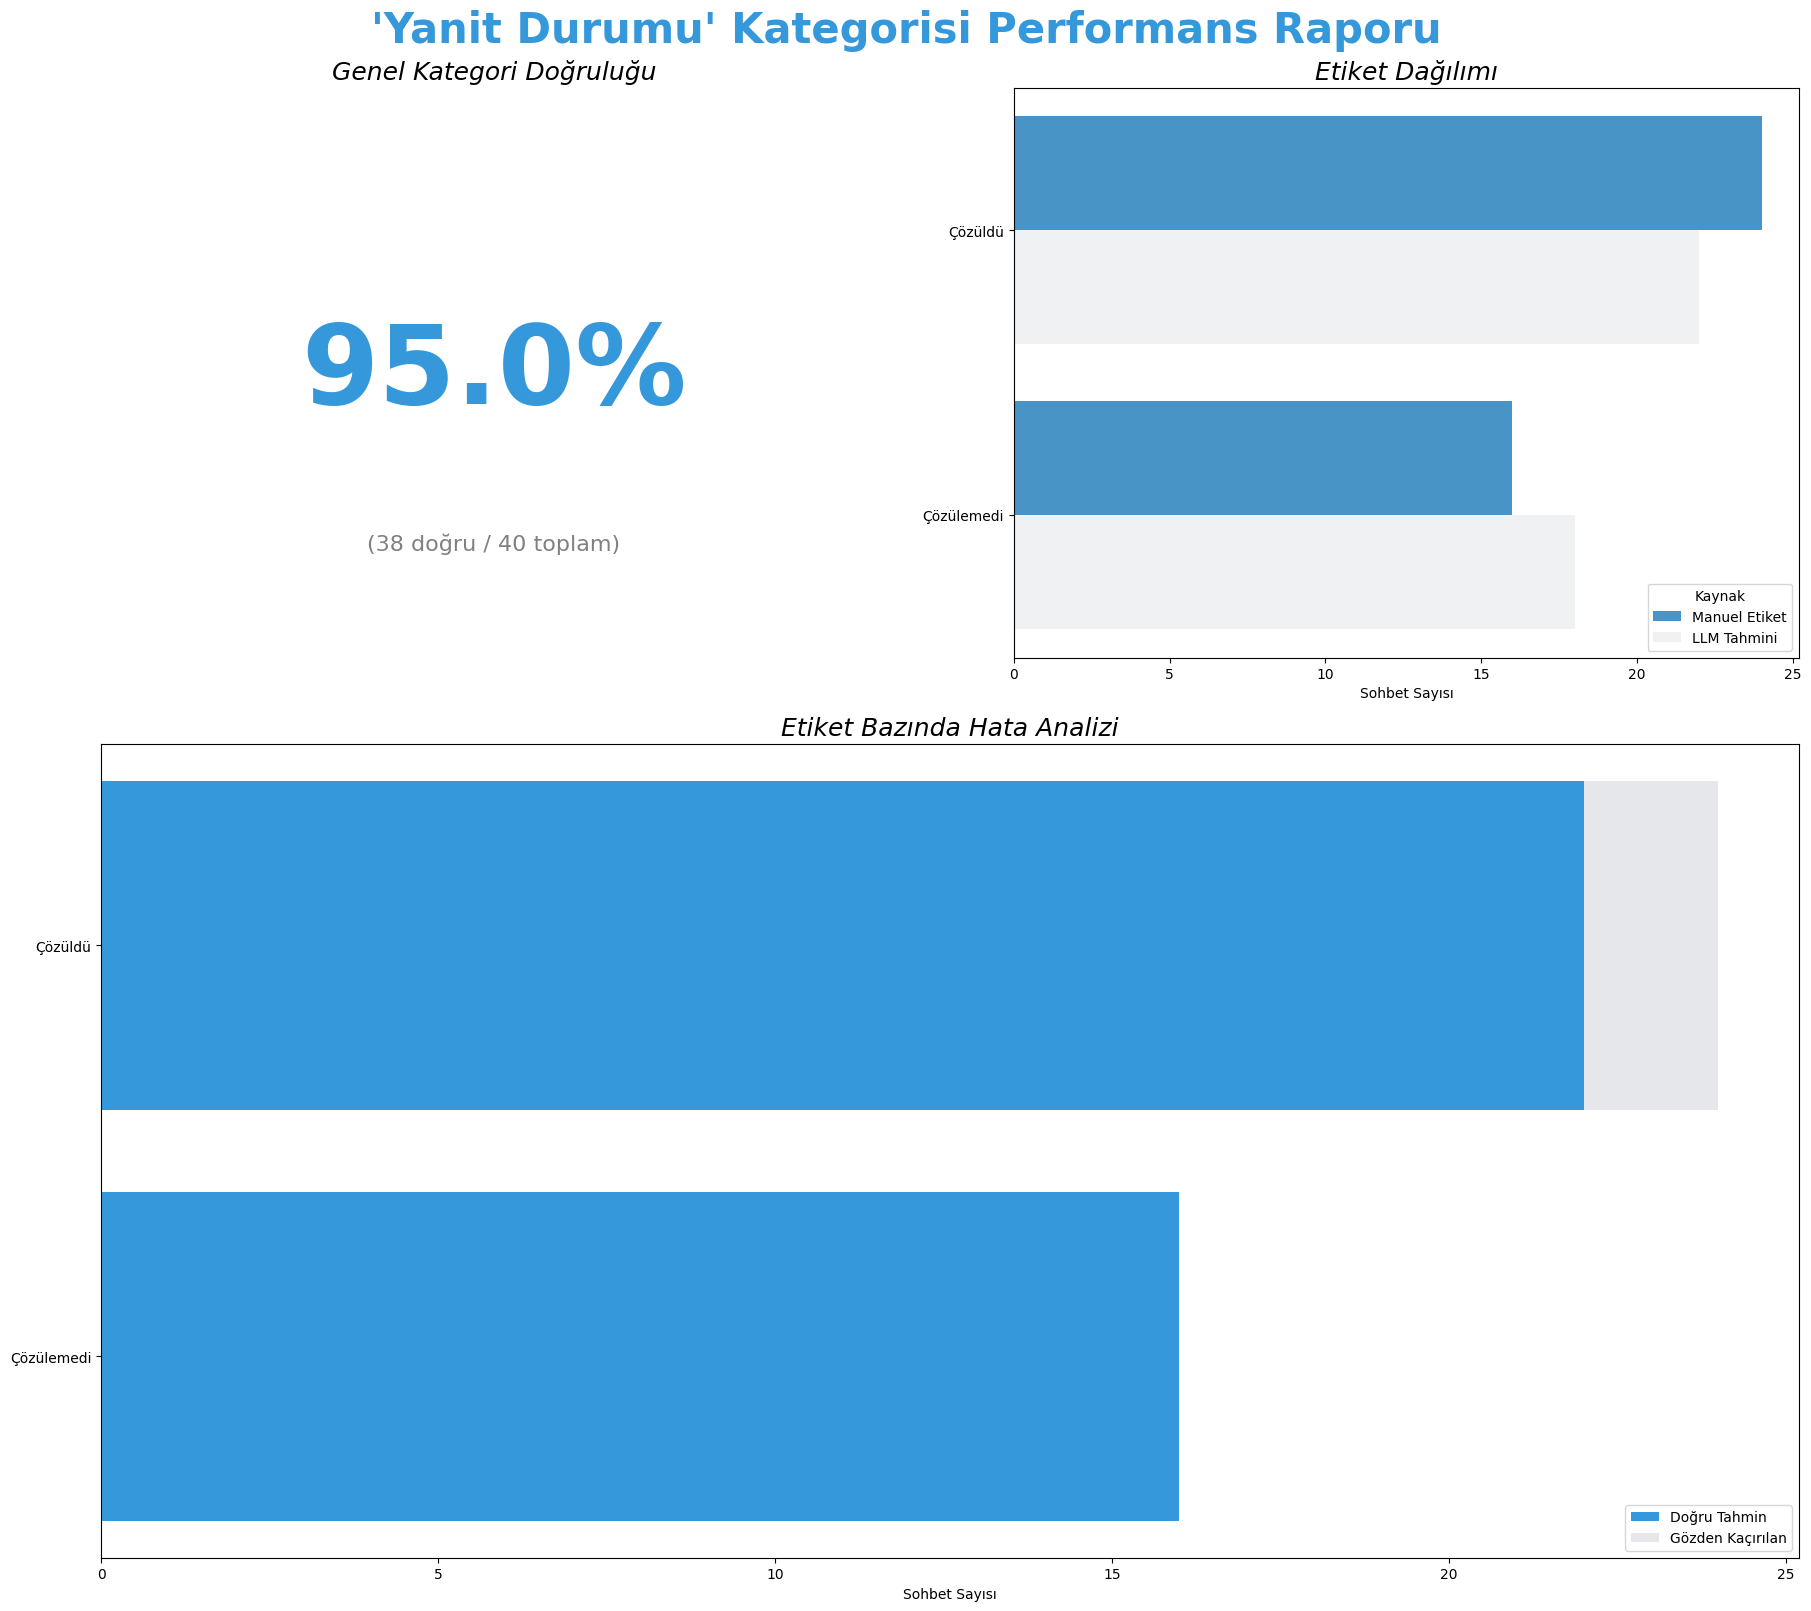

'dashboard_yanit_durumu_raporu.png' oluşturuldu.


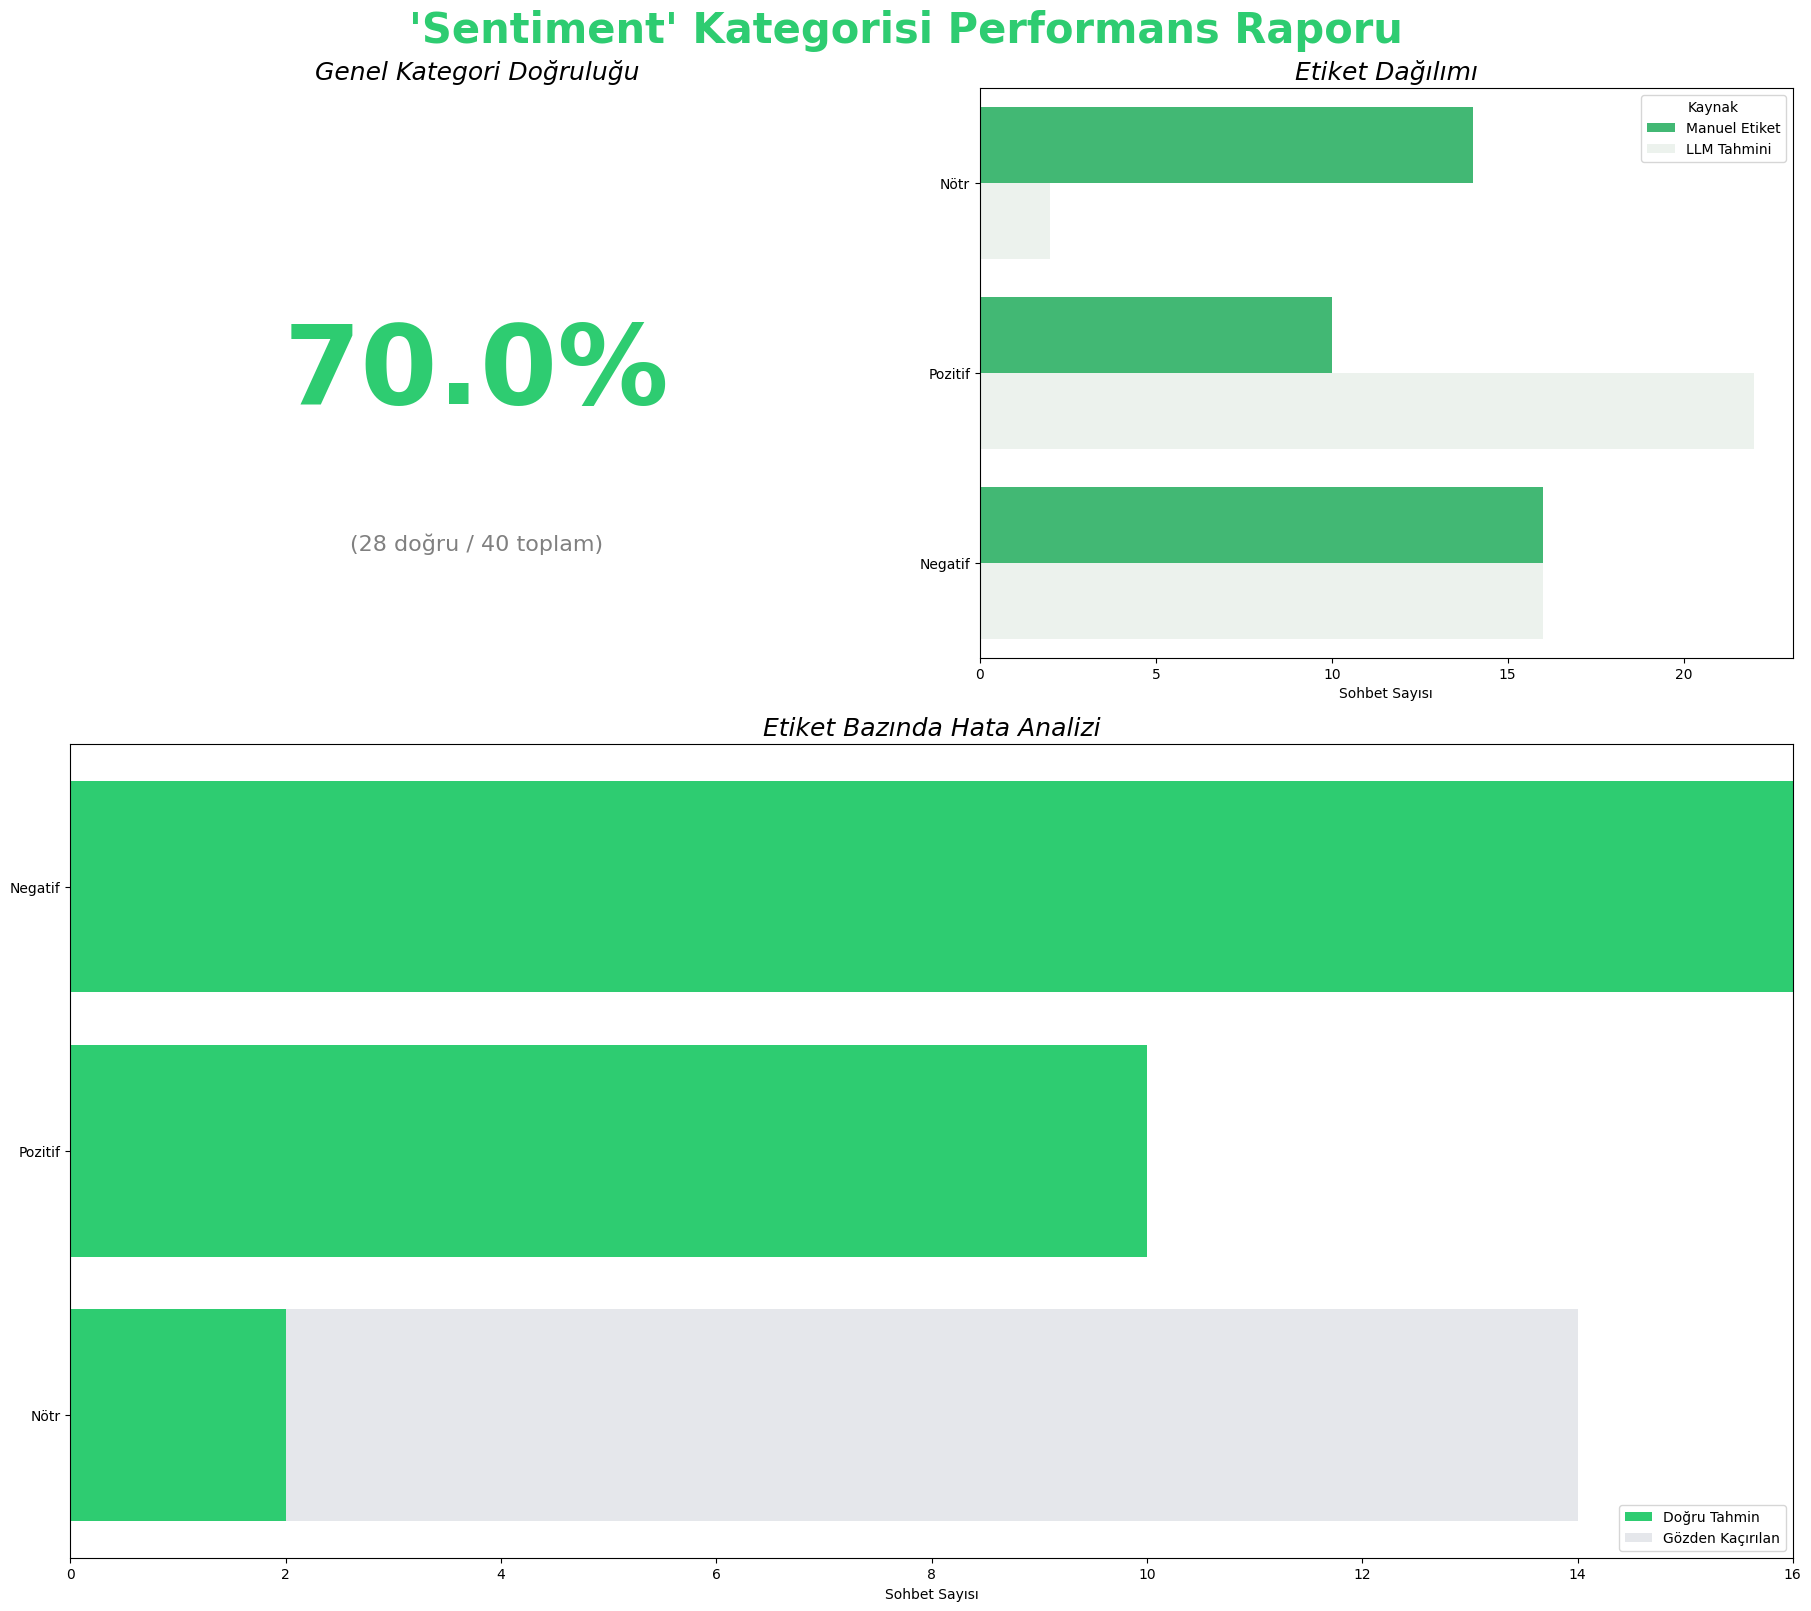

'dashboard_sentiment_raporu.png' oluşturuldu.


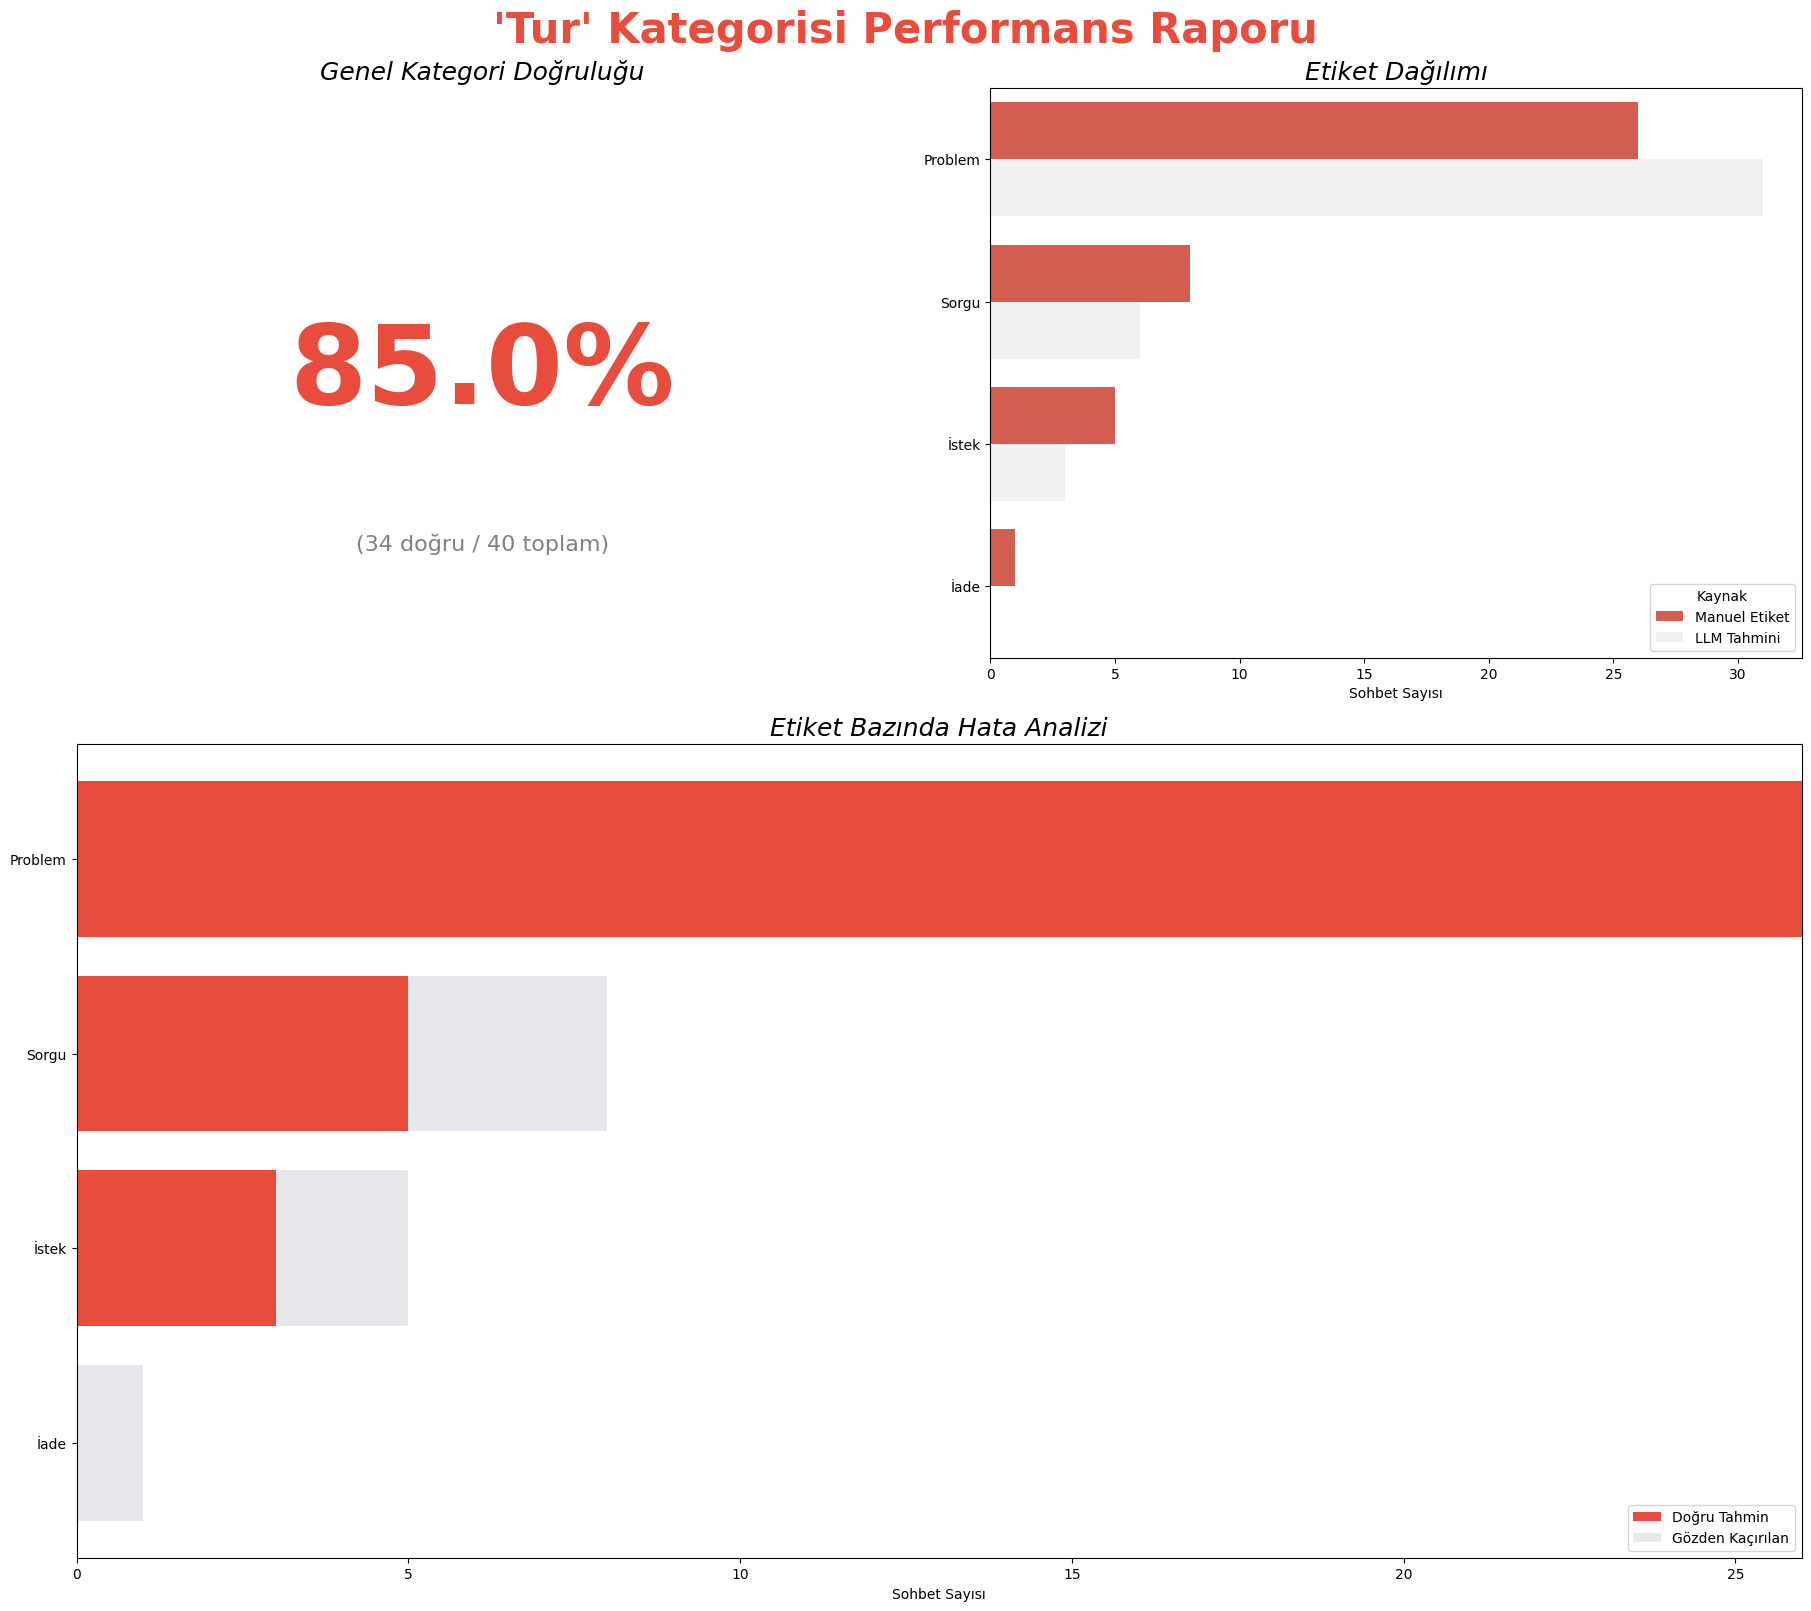

'dashboard_tur_raporu.png' oluşturuldu.


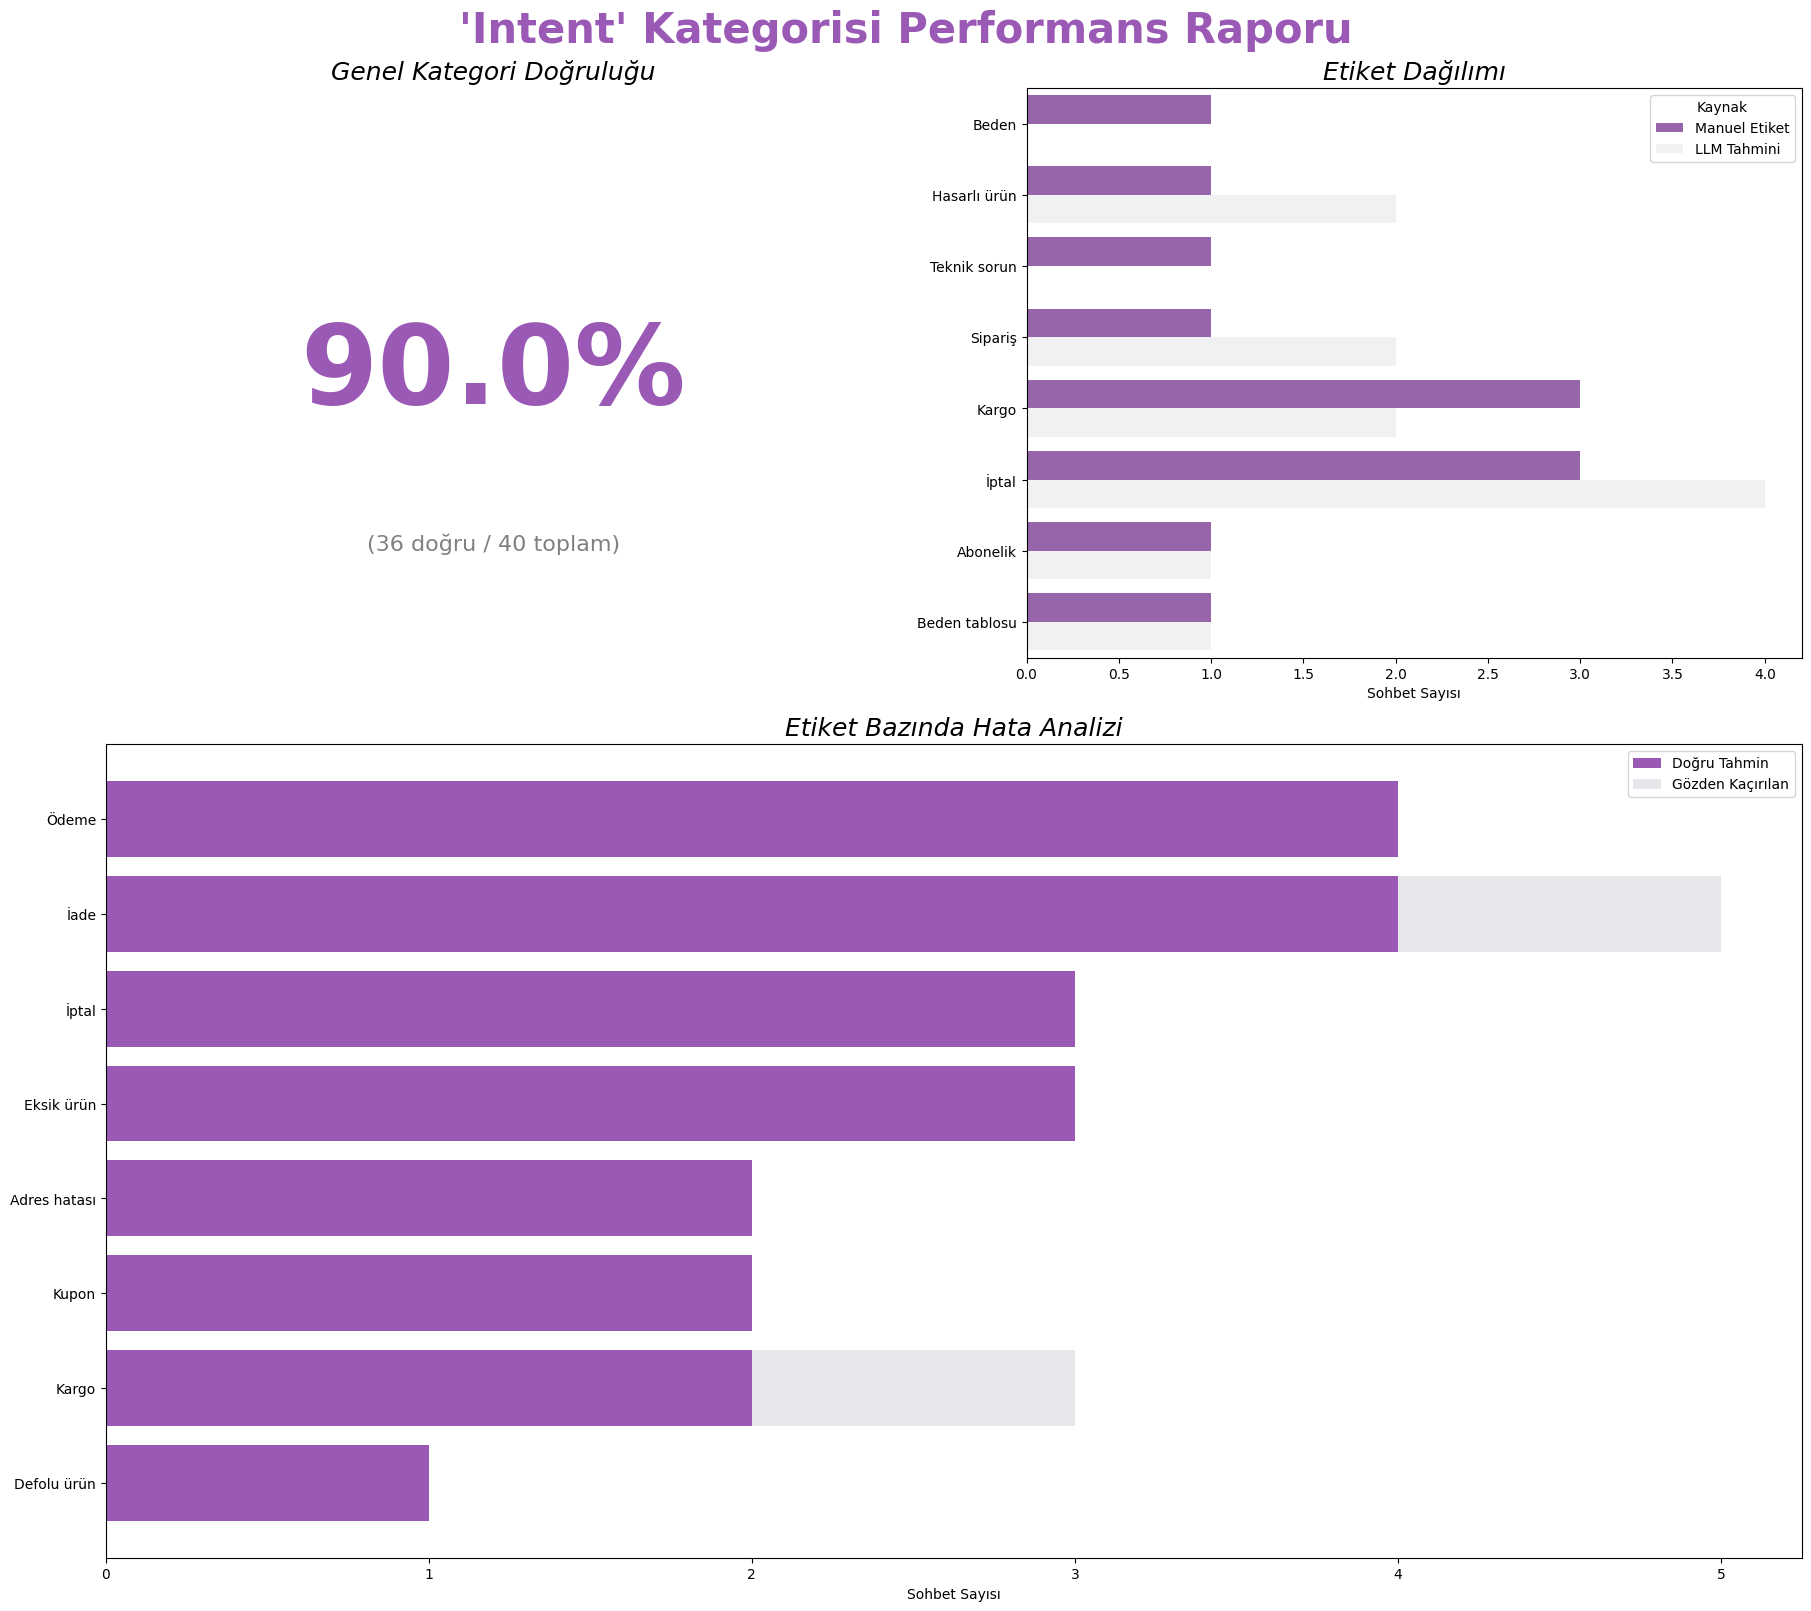

'dashboard_intent_raporu.png' oluşturuldu.


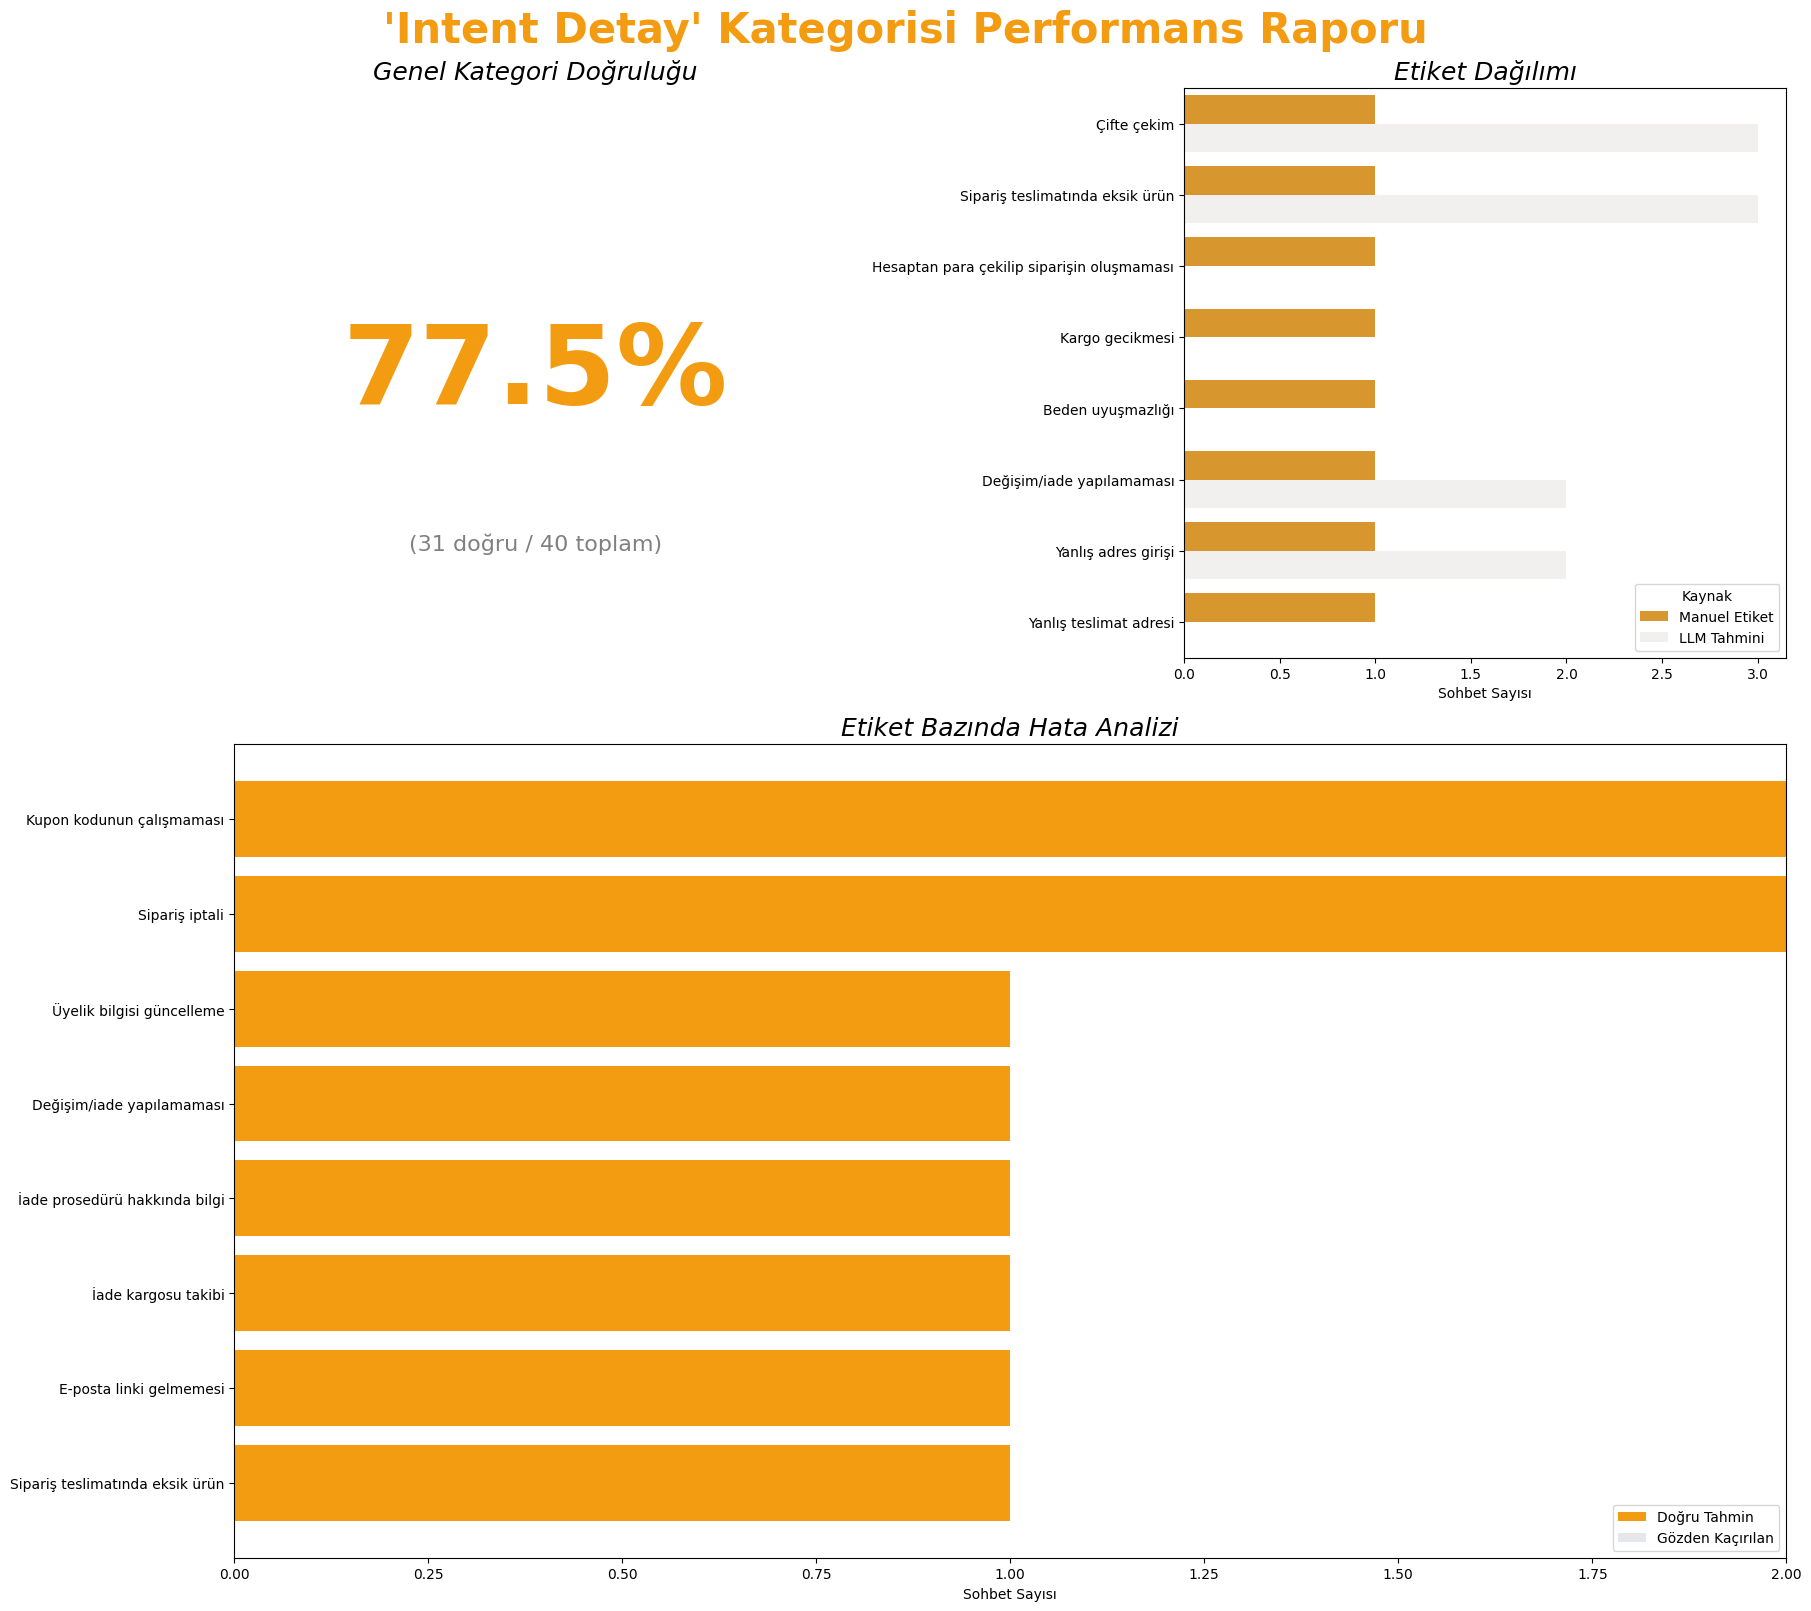

'dashboard_intent_detay_raporu.png' oluşturuldu.

--- Kategori Raporları Tamamlandı. ---

--- Adım 5: Tüm Kategorileri Özetleyen Radar Grafiği Oluşturuluyor... ---


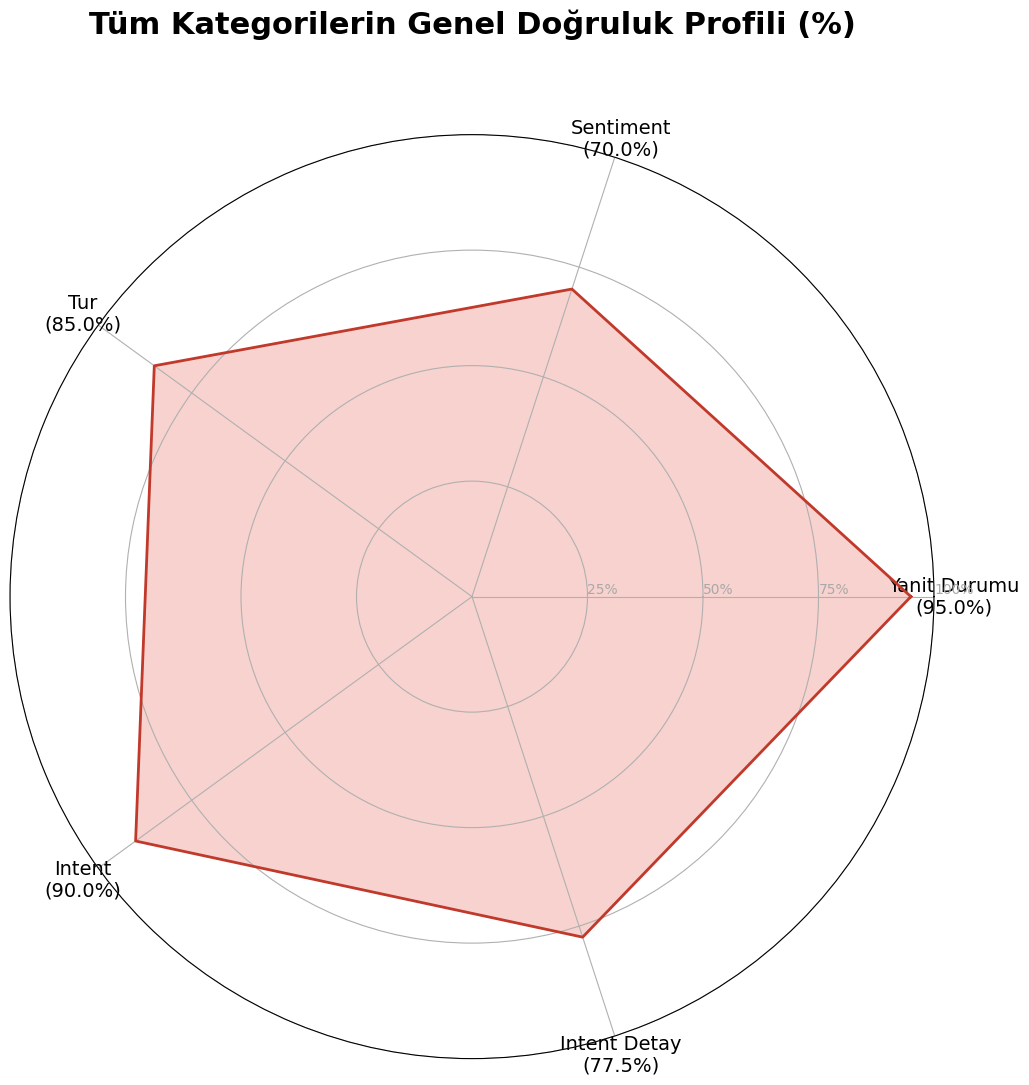

'dashboard_genel_ozet_radar.png' oluşturuldu.

--- Tüm Raporlama İşlemleri Tamamlandı. ---


In [ ]:
# ==============================================================================
# -*- coding: utf-8 -*-
# ==============================================================================
# Adım 1: Gerekli Kütüphanelerin Kurulumu
# ==============================================================================
print("--- Adım 1: Gerekli kütüphaneler kuruluyor... ---")
!pip install pandas seaborn matplotlib numpy openpyxl -q
print("--- Kurulum tamamlandı. ---")


# ==============================================================================
# Adım 2: Kütüphanelerin Import Edilmesi ve Sonuç CSV Dosyasının Yüklenmesi
# ==============================================================================
print("\n--- Adım 2: Kütüphaneler import ediliyor ve analiz sonuç dosyası isteniyor... ---")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
import numpy as np
from google.colab import files

warnings.filterwarnings('ignore')

print("Lütfen LLM analizi sonucunda indirdiğiniz 'llm_final.csv' gibi bir CSV dosyasını yükleyin.")
uploaded = files.upload()

csv_filename = next((name for name in uploaded.keys() if name.endswith('.csv')), None)
if not csv_filename:
    raise ValueError("HATA: '.csv' uzantılı sonuç dosyası yüklenmedi.")

df = pd.read_csv(csv_filename)
print(f"--- '{csv_filename}' dosyası başarıyla yüklendi. ---")


# ==============================================================================
# Adım 3: Veriyi Görselleştirmeye Hazırlama
# ==============================================================================
print("\n--- Adım 3: Veri işleniyor ve grafikler için hazırlanıyor... ---")

categories = ['yanit_durumu', 'sentiment', 'tur', 'intent', 'intent_detay']

def parse_json_string(s):
    try:
        return json.loads(s)
    except (json.JSONDecodeError, TypeError, AttributeError):
        return None

df['gt_dict'] = df['ground_truth_merged'].apply(parse_json_string)
df['pred_dict'] = df['prediction_merged'].apply(parse_json_string)

df.dropna(subset=['gt_dict', 'pred_dict'], inplace=True)
df = df[df['pred_dict'].apply(lambda x: 'error' not in x if isinstance(x, dict) else True)]

for cat in categories:
    df[f'gt_{cat}'] = df['gt_dict'].apply(lambda x: x.get(cat) if isinstance(x, dict) else None)
    df[f'pred_{cat}'] = df['pred_dict'].apply(lambda x: x.get(cat) if isinstance(x, dict) else None)

print("--- Veri işleme tamamlandı. Grafik çizimine hazır. ---")
# ==============================================================================
# Adım 4 (Versiyon 6.1 - DÜZELTİLMİŞ): Kapsamlı Performans Dashboard'ları
# ==============================================================================
print("\n--- Adım 4 (Versiyon 6.1 - DÜZELTİLMİŞ): Her Kategori için Kapsamlı Dashboard'lar Oluşturuluyor... ---")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

category_colors = {
    'yanit_durumu': '#3498db', 'sentiment': '#2ecc71', 'tur': '#e74c3c',
    'intent': '#9b59b6', 'intent_detay': '#f39c12'
}
TOP_N = 8

for category in categories:
    if df[f'gt_{category}'].dropna().empty:
        print(f"--- '{category}' kategorisi için yeterli veri bulunamadı, atlanıyor. ---")
        continue

    # === 1. Veri Hazırlığı (Bu kategoriye özel) ===
    base_color = category_colors.get(category, '#34495e')
    title_cat = category.replace('_', ' ').title()

    # --- 1a. Genel Doğruluk Verisi ---
    correct = (df[f'gt_{category}'] == df[f'pred_{category}']).sum()
    total = len(df.dropna(subset=[f'gt_{category}', f'pred_{category}']))
    accuracy = (correct / total) if total > 0 else 0

    # --- 1b. Dağılım Karşılaştırma Verisi ---
    gt_counts = df[f'gt_{category}'].value_counts().reset_index(); gt_counts.columns = ['label', 'Manuel Etiket']
    pred_counts = df[f'pred_{category}'].value_counts().reset_index(); pred_counts.columns = ['label', 'LLM Tahmini']
    combined_df = pd.merge(gt_counts, pred_counts, on='label', how='outer').fillna(0)
    combined_df['fark'] = abs(combined_df['Manuel Etiket'] - combined_df['LLM Tahmini'])
    top_diff_df = combined_df.sort_values(by='fark', ascending=False).head(TOP_N)
    tidy_df = top_diff_df.drop(columns=['fark']).melt(id_vars='label', var_name='Kaynak', value_name='Sayı')

    # --- 1c. Hata Analizi Verisi ---
    accuracy_data = []
    temp_df = df.dropna(subset=[f'gt_{category}'])
    labels_for_acc = temp_df[f'gt_{category}'].value_counts().head(TOP_N).index
    for label in labels_for_acc:
        label_df = temp_df[temp_df[f'gt_{category}'] == label]
        total_label = len(label_df)
        correct_label = (label_df[f'gt_{category}'] == label_df[f'pred_{category}']).sum()
        accuracy_data.append({'label': label, 'Doğru Tahmin': correct_label, 'Gözden Kaçırılan': total_label - correct_label})
    acc_df = pd.DataFrame(accuracy_data).sort_values(by='Doğru Tahmin')


    # === 2. Dashboard Çizimi ===
    fig = plt.figure(figsize=(18, 16), constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[0.7, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    fig.suptitle(f"'{title_cat}' Kategorisi Performans Raporu", fontsize=30, weight='bold', color=base_color)

    ax1.axis('off')
    ax1.set_title('Genel Kategori Doğruluğu', fontsize=18, style='italic')
    ax1.text(0.5, 0.5, f'{accuracy:.1%}', ha='center', va='center', fontsize=80, weight='bold', color=base_color)
    ax1.text(0.5, 0.2, f'({correct} doğru / {total} toplam)', ha='center', va='center', fontsize=16, color='grey')

    palette = sns.light_palette(base_color, n_colors=2, reverse=True)
    sns.barplot(data=tidy_df, y='label', x='Sayı', hue='Kaynak', palette=palette, orient='h', ax=ax2)
    ax2.set_title(f'Etiket Dağılımı', fontsize=18, style='italic')
    ax2.set_ylabel('')
    ax2.set_xlabel('Sohbet Sayısı')

    ax3.barh(acc_df['label'], acc_df['Doğru Tahmin'], color=base_color, label='Doğru Tahmin')
    ax3.barh(acc_df['label'], acc_df['Gözden Kaçırılan'], left=acc_df['Doğru Tahmin'], color='#E5E7EB', label='Gözden Kaçırılan')
    ax3.set_title(f'Etiket Bazında Hata Analizi', fontsize=18, style='italic')
    ax3.set_xlabel('Sohbet Sayısı')
    ax3.legend()

    filename = f"dashboard_{category}_raporu.png"
    plt.savefig(filename, dpi=120)
    plt.show()
    print(f"'{filename}' oluşturuldu.")

print("\n--- Kategori Raporları Tamamlandı. ---")


# ==============================================================================
# Adım 5: Genel Performans Özeti (Radar Grafiği)
# ==============================================================================
print("\n--- Adım 5: Tüm Kategorileri Özetleyen Radar Grafiği Oluşturuluyor... ---")

performance_metrics = {}
for cat in categories:
    correct = (df[f'gt_{cat}'] == df[f'pred_{cat}']).sum()
    total = len(df.dropna(subset=[f'gt_{cat}', f'pred_{cat}']))
    accuracy = (correct / total) * 100 if total > 0 else 0
    performance_metrics[cat.replace('_', ' ').title()] = accuracy

labels = list(performance_metrics.keys())
values = list(performance_metrics.values())
values += values[:1]
labels_with_values = [f"{label}\n({value:.1f}%)" for label, value in performance_metrics.items()]

num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='#c0392b', linewidth=2)
ax.fill(angles, values, color='#e74c3c', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels_with_values, size=14)
plt.title("Tüm Kategorilerin Genel Doğruluk Profili (%)", size=22, weight='bold', y=1.1)
ax.set_rgrids([25, 50, 75, 100], labels=["25%", "50%", "75%", "100%"], angle=0, color="darkgrey", size=10)
ax.set_ylim(0, 100)

filename = "dashboard_genel_ozet_radar.png"
plt.savefig(filename, dpi=120)
plt.show()

print(f"'{filename}' oluşturuldu.")
print("\n--- Tüm Raporlama İşlemleri Tamamlandı. ---")

## KARŞILAŞTIRMALI EXCEL DOSYASI OLUŞTURMA

In [11]:
# ==============================================================================
# Adım 1: Gerekli Kütüphanelerin Kurulumu ve Import Edilmesi
# ==============================================================================
print("--- Adım 1: Gerekli kütüphaneler kuruluyor ve import ediliyor... ---")
!pip install pandas openpyxl -q

import pandas as pd
import json
from google.colab import files
from openpyxl.styles import PatternFill

print("--- Kurulum ve import işlemleri tamamlandı. ---")


# ==============================================================================
# Adım 2: Gerekli Dosyaların Yüklenmesi (2 DOSYA)
# ==============================================================================
print("\n--- Adım 2: Lütfen gerekli dosyaları yükleyin... ---")

print("Lütfen manuel etiketleri ve sohbet metinlerini içeren 'ground_truth.xlsx' dosyasını yükleyin.")
uploaded_gt = files.upload()
gt_filename = next(iter(uploaded_gt))
df_ground_truth = pd.read_excel(gt_filename, sheet_name='sohbetler')
print(f"--- '{gt_filename}' dosyası başarıyla yüklendi. ---")

print("\nLütfen yapay zekâ tahminlerini içeren 'llm_final.csv' dosyasını yükleyin.")
uploaded_llm = files.upload()
llm_filename = next(iter(uploaded_llm))
df_llm = pd.read_csv(llm_filename)
print(f"--- '{llm_filename}' dosyası başarıyla yüklendi. ---")


# ==============================================================================
# Adım 3: Verilerin İşlenmesi ve Birleştirilmesi (NİHAİ DÜZELTME)
# ==============================================================================
print("\n--- Adım 3: Veriler işleniyor ve karşılaştırma tablosu hazırlanıyor... ---")

# --- DÜZELTME BAŞLANGICI: Sağlam Birleştirme Mantığı ---

# 1. Veri tiplerini birleştirmeden önce eşitleyelim (En yaygın hata nedenlerinden biri)
df_ground_truth['sohbet_id'] = df_ground_truth['sohbet_id'].astype(str)
if 'id' in df_llm.columns and 'sohbet_id' not in df_llm.columns:
    df_llm.rename(columns={'id': 'sohbet_id'}, inplace=True)
df_llm['sohbet_id'] = df_llm['sohbet_id'].astype(str)

# 2. Gerekli sütunları seçerek temiz kopyalar oluşturalım
sohbet_metni_sutunu = 'tam_sohbet' # Sütun adının bu olduğunu teyit ettik
categories = ['yanit_durumu', 'sentiment', 'tur', 'intent', 'intent_detay']
gt_cols_to_keep = ['sohbet_id', sohbet_metni_sutunu] + categories
df_gt_clean = df_ground_truth[gt_cols_to_keep].copy()

llm_cols_to_keep = ['sohbet_id', 'prediction', 'prediction_merged']
df_llm_clean = df_llm[llm_cols_to_keep].copy()

# 3. Temiz kopyaları birleştirelim
df_comparison = pd.merge(df_gt_clean, df_llm_clean, on='sohbet_id', how='left')

# --- DÜZELTME SONU ---


# Sütun adlarını daha anlaşılır hale getirelim
df_comparison.rename(columns={cat: f"Manual_{cat}" for cat in categories}, inplace=True)
df_comparison.rename(columns={sohbet_metni_sutunu: 'Sohbet_Metni'}, inplace=True)

# LLM tahminlerini ve Eşleşme durumlarını yeni sütunlar olarak ekleyelim
def parse_json_string(s):
    try: return json.loads(s)
    except: return {}

df_comparison['prediction_dict'] = df_comparison['prediction'].apply(parse_json_string)
df_comparison['prediction_merged_dict'] = df_comparison['prediction_merged'].apply(parse_json_string)

for cat in categories:
    df_comparison[f'LLM_{cat}'] = df_comparison['prediction_dict'].apply(lambda x: x.get(cat, 'N/A') if isinstance(x, dict) else 'N/A')
    df_comparison[f'LLM_Merged_{cat}'] = df_comparison['prediction_merged_dict'].apply(lambda x: x.get(cat, 'N/A') if isinstance(x, dict) else 'N/A')
    # Artık 'Manual_...' sütunları hatasız bulunacaktır
    df_comparison[f'Eşleşme_{cat}'] = df_comparison[f'Manual_{cat}'] == df_comparison[f'LLM_Merged_{cat}']

# Nihai raporda gösterilecek sütunları belirleyip sıralayalım
manual_cols = [f'Manual_{cat}' for cat in categories]
llm_cols = [f'LLM_{cat}' for cat in categories]
llm_merged_cols = [f'LLM_Merged_{cat}' for cat in categories]
match_cols = [f'Eşleşme_{cat}' for cat in categories]

final_columns_to_keep = ['sohbet_id', 'Sohbet_Metni'] + manual_cols + llm_merged_cols + llm_cols + match_cols
df_comparison = df_comparison[final_columns_to_keep]

print("--- Veri işleme ve birleştirme tamamlandı. ---")


# ==============================================================================
# Adım 4: Renklendirilmiş Excel Dosyasının Oluşturulması
# ==============================================================================
print("\n--- Adım 4: Renklendirilmiş Excel dosyası oluşturuluyor... ---")

output_filename = 'Karsilastirmali_Analiz_Raporu_Nihai.xlsx'
writer = pd.ExcelWriter(output_filename, engine='openpyxl')
df_comparison.to_excel(writer, sheet_name='Karsilastirma', index=False)
workbook  = writer.book
worksheet = writer.sheets['Karsilastirma']

green_fill = PatternFill(start_color='C6EFCE', end_color='C6EFCE', fill_type='solid')
red_fill = PatternFill(start_color='FFC7CE', end_color='FFC7CE', fill_type='solid')

for col_idx, col_name in enumerate(df_comparison.columns, 1):
    if col_name.startswith('LLM_Merged_'):
        match_col_name = col_name.replace('LLM_Merged_', 'Eşleşme_')
        match_col_values = df_comparison[match_col_name]

        for row_idx, matches in enumerate(match_col_values, 2):
            cell = worksheet.cell(row=row_idx, column=col_idx)
            # Eşleşme durumu True/False olmayan (NaN gibi) durumları kontrol et
            if pd.isna(matches):
                continue
            if matches:
                cell.fill = green_fill
            else:
                cell.fill = red_fill

for column in worksheet.columns:
    max_length = 0
    column_letter = column[0].column_letter

    if column[0].value == 'Sohbet_Metni':
        worksheet.column_dimensions[column_letter].width = 60
        for cell in column:
            if cell.row > 1:
                cell.alignment = cell.alignment.copy(wrap_text=True)
        continue

    for cell in column:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(str(cell.value))
        except:
            pass
    adjusted_width = (max_length + 2)
    worksheet.column_dimensions[column_letter].width = adjusted_width

writer.close()
print(f"--- '{output_filename}' dosyası başarıyla oluşturuldu! ---")


# ==============================================================================
# Adım 5: Oluşturulan Dosyanın İndirilmesi
# ==============================================================================
print("\n--- Adım 5: Oluşturulan Excel dosyası indiriliyor... ---")
files.download(output_filename)

--- Adım 1: Gerekli kütüphaneler kuruluyor ve import ediliyor... ---
--- Kurulum ve import işlemleri tamamlandı. ---

--- Adım 2: Lütfen gerekli dosyaları yükleyin... ---
Lütfen manuel etiketleri ve sohbet metinlerini içeren 'ground_truth.xlsx' dosyasını yükleyin.


Saving ground_truth.xlsx to ground_truth (8).xlsx
--- 'ground_truth (8).xlsx' dosyası başarıyla yüklendi. ---

Lütfen yapay zekâ tahminlerini içeren 'llm_final.csv' dosyasını yükleyin.


Saving llm_final.csv to llm_final (8).csv
--- 'llm_final (8).csv' dosyası başarıyla yüklendi. ---

--- Adım 3: Veriler işleniyor ve karşılaştırma tablosu hazırlanıyor... ---
--- Veri işleme ve birleştirme tamamlandı. ---

--- Adım 4: Renklendirilmiş Excel dosyası oluşturuluyor... ---
--- 'Karsilastirmali_Analiz_Raporu_Nihai.xlsx' dosyası başarıyla oluşturuldu! ---

--- Adım 5: Oluşturulan Excel dosyası indiriliyor... ---


/tmp/ipython-input-3897904679.py:128: DeprecationWarning: Call to deprecated function copy (Use copy(obj) or cell.obj = cell.obj + other).
  cell.alignment = cell.alignment.copy(wrap_text=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## NOT:
'tur' için birleştirilen kategoriler:

'Problem' başlığı altında birleştirilenler:

*   Şikayet
*   Sorun


'Sorgu' başlığı altında birleştirilenler:

*   Soru
*   Bilgi alma
